In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
from adjustText import adjust_text
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [2]:
# meta data
cluster_meta=pd.read_csv('../data/TableS7-cell_metadata.csv.gz',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('../data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


# # of sexDEs and sexDMRs

total unique sex DEs: autosomal 249 chrX 13
Exc unique  sex DEs: autosomal 209 chrX 9
Inh unique  sex DEs:  52 chrX 7
Downloading...
From: https://drive.google.com/uc?id=1S1NyvH150uI_cwmDvft4iV2PhBZkE4k5
To: /scratch/sexDMRall.tsv.gz
100%|██████████████████████████████████████| 6.33M/6.33M [00:00<00:00, 35.7MB/s]


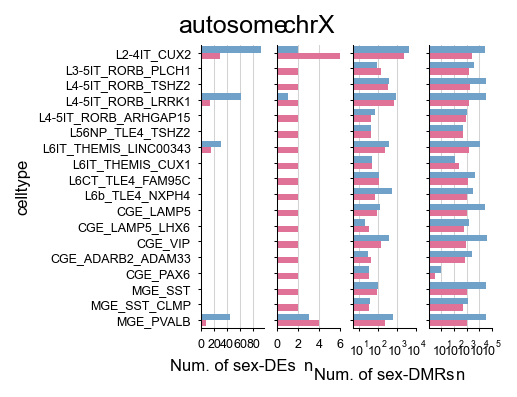

In [3]:
# DEs
fcthres=np.log2(1.2)
pthres=0.05

fulldata=pd.read_csv('../data/sexDEall.tsv.gz',sep='\t',index_col=0)
fulldata=fulldata[fulldata['celltype'].isin(cziplot.level2_order)]
fulldata['logFDR']=-np.log10(fulldata['adj.P.Val'])

data=fulldata[(fulldata['adj.P.Val']<pthres) & (np.abs(fulldata['logFC'])>fcthres)]
data.loc[:,'reg']='F'
data.loc[data['logFC']<0,'reg']='M'
data.loc[:,'chromtype']='autosome'
data.loc[data['chr']=='chrX','chromtype']='chrX'
print('total unique sex DEs: autosomal',len(data[~data['chr'].str.contains('[XYM]')].index.unique()),'chrX',len(data[data['chr']=='chrX'].index.unique()))
print('Exc unique  sex DEs: autosomal',len(data[~(data['chr'].str.contains('[XYM]'))&(data['celltype'].isin(cziplot.level2_order[0:10]))].index.unique()),'chrX',len(data[(data['chr']=='chrX')&(data['celltype'].isin(cziplot.level2_order[0:10]))].index.unique()))
print('Inh unique  sex DEs: ',len(data[~(data['chr'].str.contains('[XYM]'))&data['celltype'].isin(cziplot.level2_order[10:18])].index.unique()),'chrX',len(data[(data['chr']=='chrX')&(data['celltype'].isin(cziplot.level2_order[10:18]))].index.unique()))
de_summary=data.groupby(['celltype','chromtype','reg']).size().to_frame('n').reset_index()

# DMRs
! gdown -O /scratch/sexDMRall.tsv.gz  https://drive.google.com/file/d/1S1NyvH150uI_cwmDvft4iV2PhBZkE4k5/view?usp=drive_link --fuzzy
dmrdata=pd.read_csv('/scratch/sexDMRall.tsv.gz',sep='\t')
dmrdata=dmrdata[~dmrdata['chr'].str.contains('[YM]')]
dmrdata.loc[:,'reg']='F'
dmrdata.loc[dmrdata['areaStat']<0,'reg']='M'
dmrdata.loc[:,'chromtype']='autosome'
dmrdata.loc[dmrdata['chr']=='chrX','chromtype']='chrX'
dmr_summary=dmrdata.groupby(['celltype','chromtype','reg']).size().to_frame('n').reset_index()

fig,axs=plt.subplots(1,4,figsize=(2.5,2.5),sharey=True,dpi=dpi)

ax=axs[0]
sns.barplot(data=de_summary[de_summary['chromtype']=='autosome'], y='celltype',x='n',hue='reg',order=cziplot.level2_order,hue_order=['M','F'],palette=cziplot.sex_palette,ax=ax)
ax.set_xlabel('Num. of sex-DEs')
ax.set_xticks([0,20,40,60,80])
ax.set_title('autosome')
ax.grid(axis='x')
ax.get_legend().remove()
ax=axs[1]
sns.barplot(data=de_summary[de_summary['chromtype']=='chrX'], y='celltype',x='n',hue='reg',order=cziplot.level2_order,hue_order=['M','F'],palette=cziplot.sex_palette,ax=ax)
ax.set_xlim([0,5])
ax.set_xticks([0,2,4,6])
ax.set_title('chrX')
ax.grid(axis='x')
ax.get_legend().remove()
ax=axs[2]
sns.barplot(data=dmr_summary[dmr_summary['chromtype']=='autosome'], y='celltype',x='n',hue='reg',order=cziplot.level2_order,hue_order=['M','F'],palette=cziplot.sex_palette,ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Num. of sex-DMRs')
ax.grid(axis='x')
ax.set_xlim([5,5000])
ax.set_xticks([10,100,1000,10000])
ax.get_legend().remove()
ax=axs[3]
sns.barplot(data=dmr_summary[dmr_summary['chromtype']=='chrX'], y='celltype',x='n',hue='reg',order=cziplot.level2_order,hue_order=['M','F'],palette=cziplot.sex_palette,ax=ax)
ax.set_xscale('log')
ax.grid(axis='x')
ax.set_xticks([10,100,1000,10000,100000])
ax.set_xlim([1,100000])
ax.get_legend().remove()

# compare with Oliva et al

Downloading...
From: https://drive.google.com/uc?id=1-B0Bk6ytjlhGRbEAg5x4pISI-fefWQwz
To: /scratch/signif.sbgenes_Frontal_Cortex_BA9.txt
100%|████████████████████████████████████████| 197k/197k [00:00<00:00, 4.77MB/s]
0.2531732103417931 0.1014096980872283


Text(0.5, 1.0, 'Spearman corr =0.25, p = 1E-01')

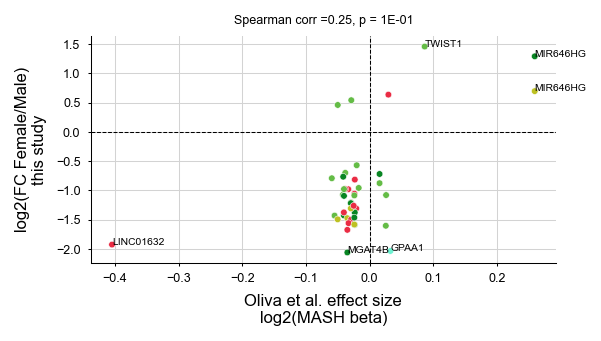

In [4]:
fulldata=pd.read_csv('../data/sexDEall.tsv.gz',sep='\t',index_col=0)
fulldata.index.name='gene_id'
fulldata=fulldata.reset_index()
fulldata['chromtype']=(fulldata['chr']=='chrX').map({True:'chrX',False:'autosome'})

! gdown -O /scratch/signif.sbgenes_Frontal_Cortex_BA9.txt  https://drive.google.com/file/d/1-B0Bk6ytjlhGRbEAg5x4pISI-fefWQwz/view?usp=drive_link --fuzzy
oliva=pd.read_csv('/scratch/signif.sbgenes_Frontal_Cortex_BA9.txt',sep='\t')
fulldata['ensid']=fulldata['gene_id'].str.replace(r'\.[0-9]+','',regex=True)
oliva['ensid']=oliva['gene'].str.replace(r'\.[0-9]+','',regex=True)

oliva=oliva.merge(fulldata,on='ensid',how='left')
oliva=oliva[oliva['chromtype']=='autosome']
oliva=oliva[(oliva['adj.P.Val']<pthres)&(oliva['logFC'].abs()>fcthres)]
r,p=sc.stats.spearmanr(oliva['effsize'],oliva['logFC'])
print(r,p)
plt.figure(figsize=(4,2),dpi=150)
g=sns.scatterplot(data=oliva,x='effsize',y='logFC',s=10,
                 hue='celltype',palette=level2_palette,hue_order=level2_order)
plt.grid()
plt.xlabel('Oliva et al. effect size\nlog2(MASH beta)')
plt.ylabel('log2(FC Female/Male)\nthis study')
g.get_legend().remove()
plt.axvline(x=0,linestyle='--',c='k',linewidth=0.5)
plt.axhline(y=0,linestyle='--',c='k',linewidth=0.5)
  
gshow=oliva[(oliva['effsize'].abs()>.06)|(oliva['logFC'].abs()>2)]
texts=[]
for i,gi in gshow.iterrows():
    texts.append(plt.text(gi['effsize'],gi['logFC'],gi['gene_name'],fontsize=5))
plt.title(f'Spearman corr ={r:.2f}, p = {p:.0E}',fontsize=6)

# DEGs in multiple cell types

249  autosomal genes


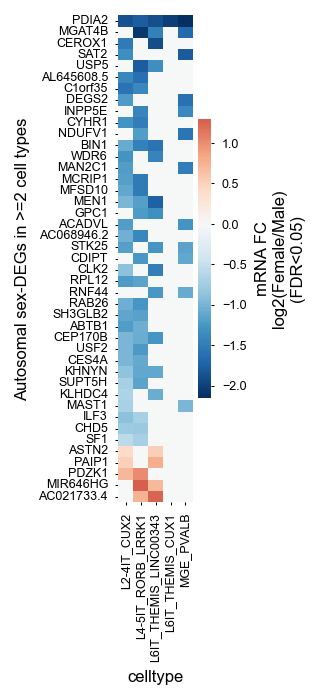

In [5]:
data_df=data.loc[data[~(data['chr'].str.contains('[XYM]'))&(np.abs(data['logFC'])>fcthres)\
                                  &(data['adj.P.Val']<pthres)].index.unique()]\
                                    .pivot(columns='celltype',values='logFC')
data_df.index=data_df.index.map(genedict_idtoname)
print(len(data_df),' autosomal genes')

celltypes_show = [c for c in level2_order if c in data_df.columns]
data_df=data_df.loc[:,celltypes_show]
ncelltypes = (~data_df.isna()).sum(axis=1)
data_df = data_df.loc[ncelltypes>=2]
data_df = data_df.loc[:,(~data_df.isna()).sum(axis=0)>0]
data_df = data_df.iloc[data_df.mean(axis=1).argsort()]
data_df = data_df.fillna(0)
fig=plt.figure(figsize=(.8,data_df.shape[0]*.1),dpi=150)
ax=sns.heatmap(data_df,cmap='RdBu_r',center=0,
               cbar_kws={'label':f'mRNA FC\nlog2(Female/Male)\n(FDR<{pthres})','shrink':1.5},
               xticklabels=True,yticklabels=True,
              )
plt.ylabel('Autosomal sex-DEGs in >=2 cell types')
leg=ax.get_legend()

# escapee

In [6]:
# ! gdown -O /scratch/2013_lister_escapee_table4.csv.gz  https://drive.google.com/file/d/1CSSVOKniHuoupCl7BLYZWFzq8Aj8KsWn/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/2017_GTX_escapee_table1.csv.gz  https://drive.google.com/file/d/1mFuszO8zyaKXwuo8qfzf023CR64pi-c3/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/intragenic_mCH.tsv.gz  https://drive.google.com/file/d/139rzP0JKDJ6IkODeeyadEl6V-HIDeDVh/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/allcelltypes_donoraveage_log2cpm+1_chrX.tsv.gz  https://drive.google.com/file/d/1r8kWCv50_66XcibjntJiwV-IV1yWiaPR/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/mCH_genebody_female_male_ratio.tsv.gz  https://drive.google.com/file/d/1mz6QXHrhYfLbPlHr3bMoR-QO1wjUlc3S/view?usp=drive_link --fuzzy

# reference
escapee_mukamel=pd.read_csv('/scratch/2013_lister_escapee_table4.csv.gz',index_col=0)
escapee=pd.read_csv('/scratch/2017_GTX_escapee_table1.csv.gz',index_col='Gene name')
escapee.index=escapee.index.str.split('.').str[0]
escapee = escapee[~escapee.index.duplicated(keep='first')]
ref=escapee_mukamel[['Note']].join(escapee[['Combined XCI status']],how='outer')
ref=ref[ref.index.notna()].replace(np.nan,'no annotation')
lut={'no annotation':'grey','Inactivated genes':'k',' Confirmed escapee':'b', 'Novel predicted escapee':'r',
     'Escapee genes with female hypo-mCG and hypo-mCH':'C0','Escapee genes with female hyper-mCG and hypo-mCH':'C1'}
ref['color']=ref['Note'].map(lut)

# our criteria for escapee
dfch=pd.read_csv('/scratch/intragenic_mCH.tsv.gz',sep='\t',index_col=0,header=[0,1])
dfch=dfch.loc[gene_meta[gene_meta['chr']=='chrX'].index].dropna()
dfch=dfch.T
dfch['sex']=dfch.index.get_level_values(1).str[1]
dfch=dfch[dfch['sex']=='F'].drop(columns='sex')
dfch=dfch.reset_index().groupby(['level_0']).mean()
dfch=dfch[dfch.mean()[dfch.mean()>0.02].index]
goidna=set(dfch.columns)

exp=pd.read_csv('/scratch/allcelltypes_donoraveage_log2cpm+1_chrX.tsv.gz',sep='\t',index_col=0).dropna()
exp=exp.T
exp=exp[exp.min()[exp.min()>0].index]
goirna=set(exp.columns)

dfratio=pd.read_csv('/scratch/mCH_genebody_female_male_ratio.tsv.gz',sep='\t',index_col=0).replace([np.inf,-np.inf],np.nan).dropna().T
dfratio=dfratio[dfratio.max()[dfratio.max()>1.5].index]
goimch=set(dfratio.columns)

goi=goidna.intersection(goimch).intersection(goirna).intersection(set(gene_meta[gene_meta['fn'].isin(['protein_coding','lncRNA'])].index))
goi=list({genedict_idtoname[g] for g in goi})+['XIST']
goi=[ x for x in goi if "-" not in x ]

summary=pd.read_csv('/scratch/mCH_genebody_female_male_ratio.tsv.gz',sep='\t',index_col=0)
summary.index=summary.index.map(genedict_idtoname)
summary=summary.loc[goi]

summary=summary.join(ref[['Combined XCI status','Note']],how='left')
summary['Combined XCI status']=summary['Combined XCI status'].fillna('no annotation')
summary['Note']=summary['Note'].fillna('no annotation')
lut={'no annotation':'white', 'inactive':'k','escape':'r', 'variable':'b'}
col_colors=summary['Combined XCI status'].map(lut)
lut2={'no annotation':'white','Inactivated genes':'k',' Confirmed escapee':'r', 'Novel predicted escapee':'r',
     'Escapee genes with female hypo-mCG and hypo-mCH':'C0','Escapee genes with female hyper-mCG and hypo-mCH':'C1'}
col_colors2=summary['Note'].map(lut2)
color_df = pd.DataFrame({"Lister2013": col_colors2,"GTEX2017": col_colors}, index=summary.index)

summary2=summary.iloc[:,:-2].copy()
summary2[summary2<1]=np.nan
gene_order=summary.mean(axis=1).sort_values(ascending=False).index

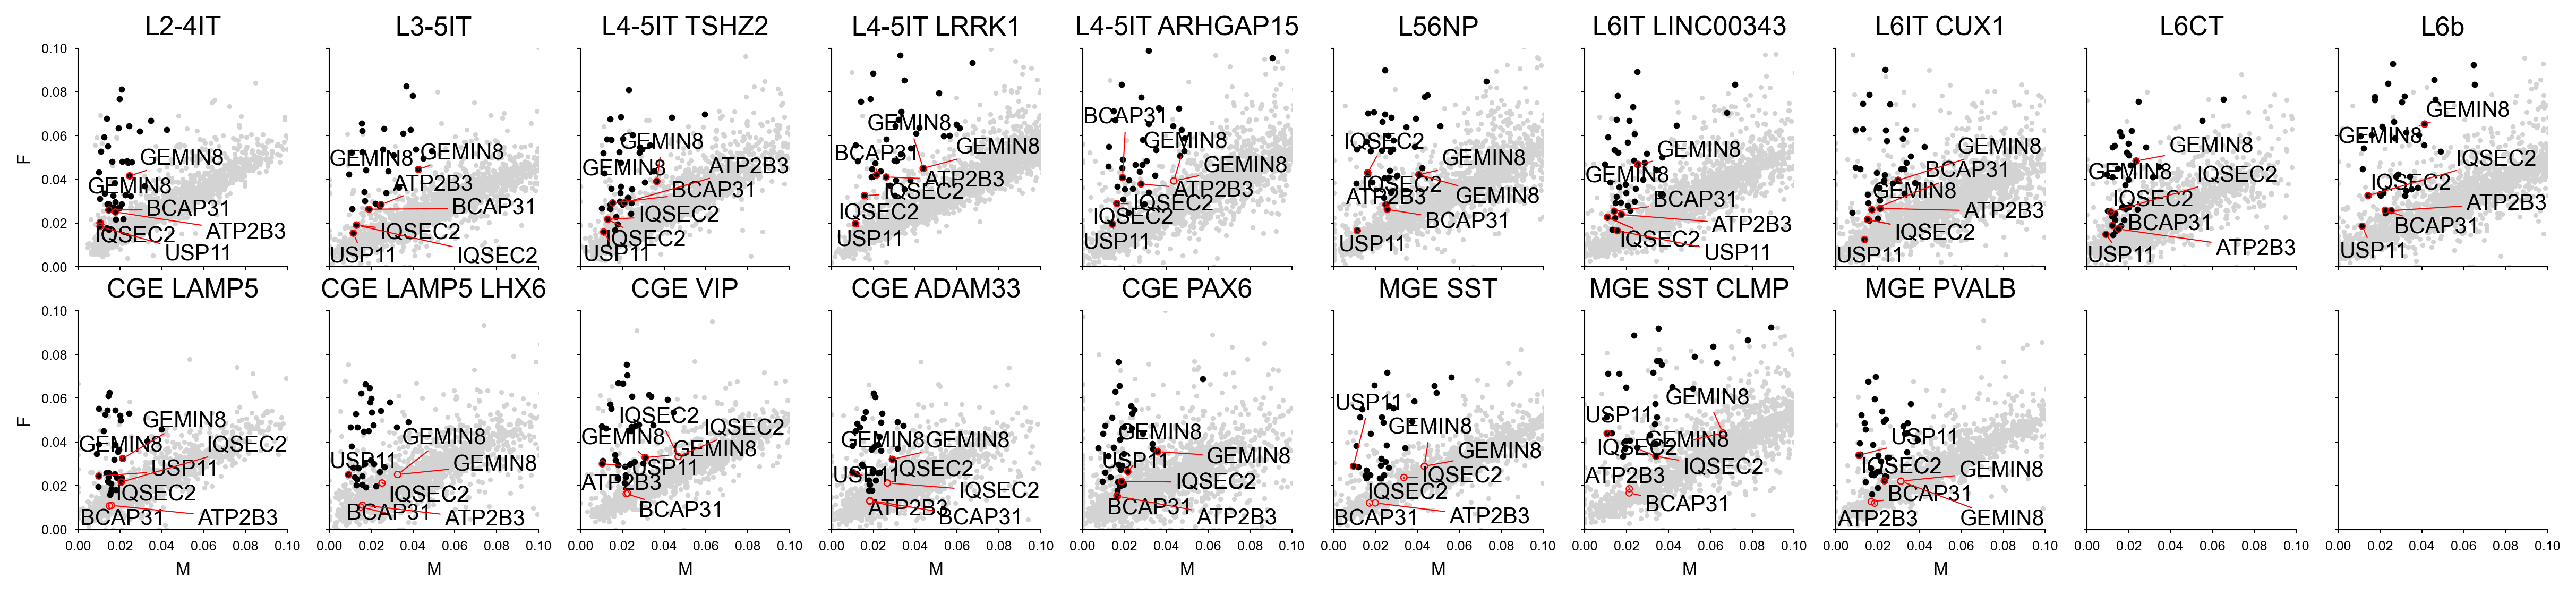

In [7]:
dfch_scatter=pd.read_csv('/scratch/intragenic_mCH.tsv.gz',sep='\t',index_col=0,header=[0,1])
dfch_scatter=dfch_scatter.loc[gene_meta[gene_meta['chr']=='chrX'].index]
dfch_scatter.index=dfch_scatter.index.map(genedict_idtoname)

def x_scatter(celltype,gois,ax):
    df_sub=dfch_scatter.xs(celltype,axis=1).T
    df_sub['sex']=df_sub.index.str[1]
    df_sub=df_sub.groupby('sex').mean().T
    df_sub = df_sub[~df_sub.index.duplicated()]
    sns.scatterplot(x='M',y='F',data=df_sub,s=5,ax=ax,linewidth=0,color='lightgrey',rasterized=True)
    lims = [0,0.1]
    plt.xlim(lims)
    plt.ylim(lims)
    genes=summary2[celltype].dropna().index.to_list()
    ax.scatter(x=df_sub.loc[genes]['M'],y=df_sub.loc[genes]['F'],s=8, color='k', linewidth=0)
    genes=gois
    ax.scatter(x=df_sub.loc[genes]['M'],y=df_sub.loc[genes]['F'],s=8, facecolors='none', edgecolors='r', linewidth=0.5)
    ax.set_title(cziplot.celltype_simdic[celltype])
    texts=[]
    for i, txt in enumerate(genes):
        test=ax.text(df_sub.loc[txt,'M'], df_sub.loc[txt,'F'],txt)
        texts.append(test)
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red',linewidth=0.5),fontsize=6,ax=ax)
    

genes=['GEMIN8','IQSEC2','USP11','BCAP31','ATP2B3','GEMIN8','IQSEC2'] 
fig,axs=plt.subplots(2,10,figsize=(20,4),dpi=300,sharex=True,sharey=True)
for i,celltype in enumerate(level2_order):
    ax=axs[i//10,i%10]
    x_scatter(celltype,genes,ax=ax)

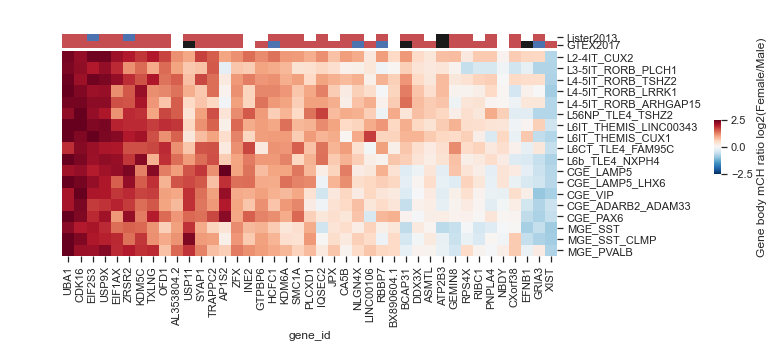

In [8]:
sns.set(style="ticks",font_scale=1)
ax=sns.clustermap(np.log2(summary.loc[gene_order].drop(columns=['Combined XCI status','Note']).T),
                row_cluster=False,col_cluster=False,
                cbar_kws={'shrink':0.8,
                            'label':'Gene body mCH ratio log2(Female/Male)'},
                  cmap='RdBu_r',center=np.log2(1),vmax=2.5,vmin=-2.5,
                col_colors=color_df,
                xticklabels=True,
                yticklabels=True,
                rasterized=False,
                dendrogram_ratio=0.1,
                cbar_pos=(1.0,.5,.01,.15),
                figsize=(10,5)
           )